# Project Title
### Data Engineering Capstone Project

#### Project Summary
The goal of this project is to create an ETL pipeline that ingests I94 immigration data along with supplementary datasets on temperature, US demographics, and airport codes, cleans the data, and loads it into fact and dimension tables to allow for analytical queries (e.g. SQL). We could then ask questions related to trends in immigration and understand. 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [100]:
# Do all imports and installs here
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import os
import helper

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *

pd.set_option('max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1: Scope the Project and Gather Data

#### Scope 
*Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use?*
* Project description: In this project, I plan to create an analytics database that will make it easy to query information around US immigration trends such as the temperature or demographic differences between source and destination countries.

* Data Used: I used the data from the Udacity provided project which includes immigration, temperature, demographic, and airport data.
* End Solution: I intend to create an ETL pipeline that will load the provided data from sources to staging tables before procesing and cleaning it into fact and dimension tables that can be easily queried via Python. An application layer could even be built on top of of this backend data warehouse. 

* Tools Used: Python - Pandas and PySpark

#### Describe and Gather Data 
*Describe the data sets you're using. Where did it come from? What type of information is included?*

* **I94 Immigration Data:**  This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. [This](https://travel.trade.gov/research/reports/i94/historical/2016.html) is where the data comes from.
* **World Temperature Data:** This dataset came from Kaggle and contains various temperature reports from cities. You can read more about it [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
* **U.S. City Demographic Data:** This data comes from [Opendatasoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/) and contains information about the demographics of all US cities and census-designated places with a population greater than or equal to 65,000 from a 2015 Survey.
* **Airport Code Table:** This is a simple table of airport codes and corresponding cities. It comes from [here](https://datahub.io/core/airport-codes#data).

In [2]:
df_airport = pd.read_csv("airport-codes_csv.csv")
df_demographics = pd.read_csv("us-cities-demographics.csv", sep=';')
df_temperature = pd.read_csv('../../data2/GlobalLandTemperaturesByCity.csv')

#### Airport Data
| Column       | Description                                       |
|--------------|---------------------------------------------------|
| ident        | unique identifier                                 |
| type         | type of airport                                   |
| name         | name of airport                                   |
| elevation_ft | elevation of airport (feet)                       |
| continent    | continent                                         |
| iso_country  | ISO code for the airport's country                |
| iso_region   | ISO code for the airport's region                 |
| municipality | city of airport                                   |
| gps_code     | GPS code of airport                               |
| iata_code    | IATA airport code / location identifier           |
| local_code   | local code of the airport                         |
| coordinates  | latitude and longitude coordinates of the airport |

In [3]:
print(df_airport.shape)
print(df_airport.info())
display(df_airport.head())

(55075, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB
None


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


#### Demographic Data

| Column                 | Description                                  | Type    |
|------------------------|----------------------------------------------|---------|
| City                   | Name of US city                              | string  |
| State                  | Name of US state                             | string  |
| Median Age             | Median age of city population                | float   |
| Male Population        | Count of male population in the city         | integer |
| Female Population      | Count of female population in the city       | integer |
| Total Population       | Count of total population in the city        | integer |
| Number of Veterans     | Count of veterans in the city                | integer |
| Foreign-born           | Count of foreign born population in the city | integer |
| Average Household Size | Average household size in the city           | float   |
| State                  | State code (abbreviation)                    | string  |
| Race                   | Race                                         | string  |
| Count                  | Count of individuals by race                 | integer |

In [4]:
print(df_demographics.shape)
print(df_demographics.info())
display(df_demographics.head())

(2891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB
None


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Temperature Data
| Column                        | Description                                |
|-------------------------------|--------------------------------------------|
| dt                            | Date in format YYYY-MM-DD                  |
| AverageTemperature            | Average temperature in celsius             |
| AverageTemperatureUncertainty | 95% confidence interval around the average |
| City                          | City name                                  |
| Country                       | Country Name                               |
| Latitude                      | Latitude and direction                     |
| Longitude                     | Longitude and direction                    |

In [5]:
print(df_temperature.shape)
print(df_temperature.info())
display(df_temperature.head())

(8599212, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB
None


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### Immigration Data
| Column   | Description                                                                           |
|----------|---------------------------------------------------------------------------------------|
| cicid    | Unique ID for a given record                                                          |
| i94yr    | 4 digit year                                                                          |
| i94mon   | Numeric month                                                                         |
| i94cit   | 3 digit code for immigrant country of birth                                           |
| i94res   | 3 digit code for immigrant country of residence                                       |
| i94port  | Port of admission                                                                     |
| arrdate  | Arrival date in the USA                                                               |
| i94mode  | Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)                 |
| i94addr  | State of arrival in the USA                                                           |
| depdate  | Departure Date from the USA.                                                          |
| i94bir   | Age of Respondent in Years                                                            |
| i94visa  | Visa codes collapsed into three categories: (1 = Business; 2 = Pleasure; 3 = Student) |
| count    | Used for summary statistics                                                           |
| dtadfile | Character Date Field - Date added to I-94 Files                                       |
| visapost | Department of State where where Visa was issued                                       |
| occup    | Occupation that will be performed in U.S.                                             |
| entdepa  | Arrival Flag - admitted or paroled into the U.S.                                      |
| entdepd  | Departure Flag - Departed, lost I-94 or is deceased                                   |
| entdepu  | Update Flag - Either apprehended, overstayed, adjusted to perm residence              |
| matflag  | Match flag - Match of arrival and departure records                                   |
| biryear  | 4 digit year of birth                                                                 |
| dtaddto  | Character Date Field - Date to which admitted to U.S.                                 |
| gender   | Non-immigrant sex                                                                     |
| isnum    | INS number                                                                            |
| airline  | Airline used to arrive in U.S.                                                        |
| admnum   | Admission Number                                                                      |
| fltno    | Flight number of Airline used to arrive in U.S.                                       |
| visatype | Class of admission legally admitting the non-immigrant to temporarily stay in U.S.    |

In [10]:
%%time
spark = SparkSession\
            .builder.\
            config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
            .enableHiveSupport()\
            .getOrCreate()
df_immigration = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
df_immigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [7]:
df_immigration.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,37.0,2.0,1.0,None,None,None,T,None,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,20130811,SEO,None,G,None,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,None,None,T,O,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,20160401,None,None,O,O,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,4.0,2.0,1.0,20160401,None,None,O,O,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [8]:
print(len(df_immigration.columns))

28


In [9]:
df_immigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [10]:
%%time
df_immigration.count()

CPU times: user 2.25 ms, sys: 4.24 ms, total: 6.49 ms
Wall time: 33.4 s


3096313

In [28]:
country_lookup = helper.extract_lookup('I94_SAS_Labels_Descriptions.SAS', 'i94cntyl', ['country_code', 'country'])
country_lookup['country'] = country_lookup['country'].str.title()
display(country_lookup.head())
print(len(country_lookup.drop_duplicates()))
print(len(country_lookup))

,country_code,country
0,582,"Mexico Air Sea, And Not Reported (I-94, No Lan..."
1,236,Afghanistan
2,101,Albania
3,316,Algeria
4,102,Andorra


289
289


In [12]:
state_lookup = helper.extract_lookup('I94_SAS_Labels_Descriptions.SAS', 'i94addrl', ['country_code', 'state'])
display(state_lookup.head())
print(len(state_lookup.drop_duplicates()))
print(len(state_lookup))

,country_code,state
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


55
55


In [13]:
# #write to parquet
# df_spark.write.parquet("sas_data")
# df_spark=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.  
*In the plots below we can see the columns for each of the dataframes and the percentage of missing data. We decided to exclude airport data from our project.*
#### Cleaning Steps
Document steps necessary to clean the data

Based on the EDA below, we take the following data cleaning steps:
* df_immigration:
    * drop `occup`, `entdepu`, `insnum` which are mostly missing values
    * replace null values for `i94addr` with '99' for 'All Other Codes'
* df_demographics
    * drop records with missing values for `Male Population`, `Female Population`, `Number of Veterans`, `Foreign-born`, `Average Household Size`
* df_temperature
    * drop records with missing values for `AverageTemperature` 

In [14]:
%%bash
ls ../../data/18-83510-I94-Data-2016/

i94_apr16_sub.sas7bdat
i94_aug16_sub.sas7bdat
i94_dec16_sub.sas7bdat
i94_feb16_sub.sas7bdat
i94_jan16_sub.sas7bdat
i94_jul16_sub.sas7bdat
i94_jun16_sub.sas7bdat
i94_mar16_sub.sas7bdat
i94_may16_sub.sas7bdat
i94_nov16_sub.sas7bdat
i94_oct16_sub.sas7bdat
i94_sep16_sub.sas7bdat


In [15]:
%%time
print(df_immigration.distinct().count())
print(df_immigration.count())

3096313
3096313
CPU times: user 13.2 ms, sys: 5.89 ms, total: 19.1 ms
Wall time: 1min 37s


In [16]:
df_immigration.select('cicid').distinct().count()

3096313

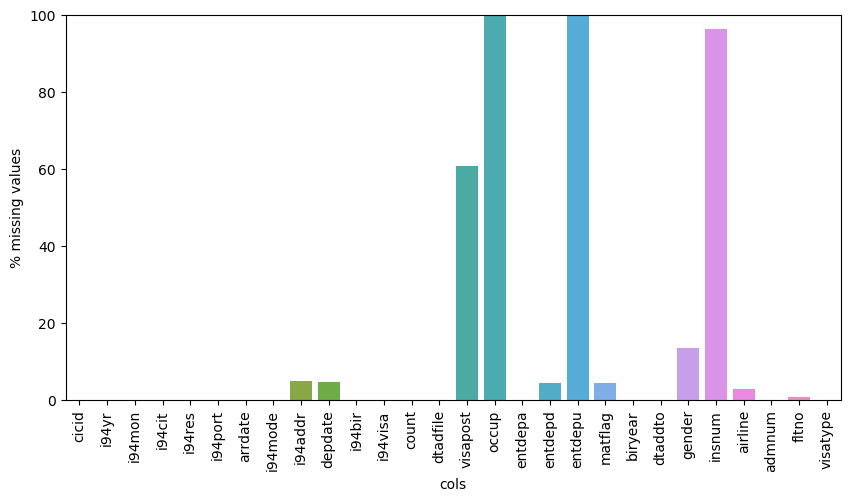

CPU times: user 904 ms, sys: 141 ms, total: 1.05 s
Wall time: 2min 18s


,cols,values,% missing values
0,cicid,0,0.000000
1,i94yr,0,0.000000
2,i94mon,0,0.000000
3,i94cit,0,0.000000
4,i94res,0,0.000000
5,i94port,0,0.000000
6,arrdate,0,0.000000
7,i94mode,239,0.007719
8,i94addr,152592,4.928184
9,depdate,142457,4.600859


In [17]:
%%time
helper.view_missing_values(df_immigration)

Airport Dataset


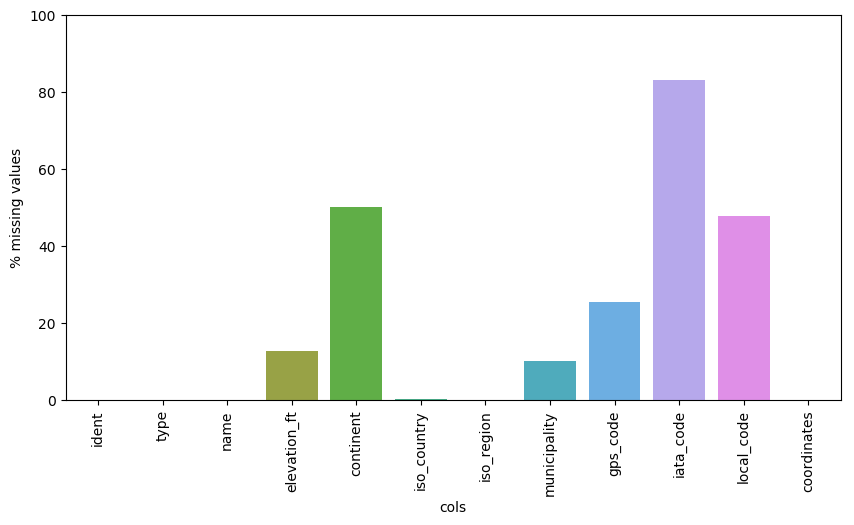

,cols,values,% missing values
0,ident,0,0.000000
1,type,0,0.000000
2,name,0,0.000000
3,elevation_ft,7006,12.720835
4,continent,27719,50.329551
5,iso_country,247,0.448479
6,iso_region,0,0.000000
7,municipality,5676,10.305946
8,gps_code,14045,25.501589
9,iata_code,45886,83.315479


55075
55075
Demographics Dataset


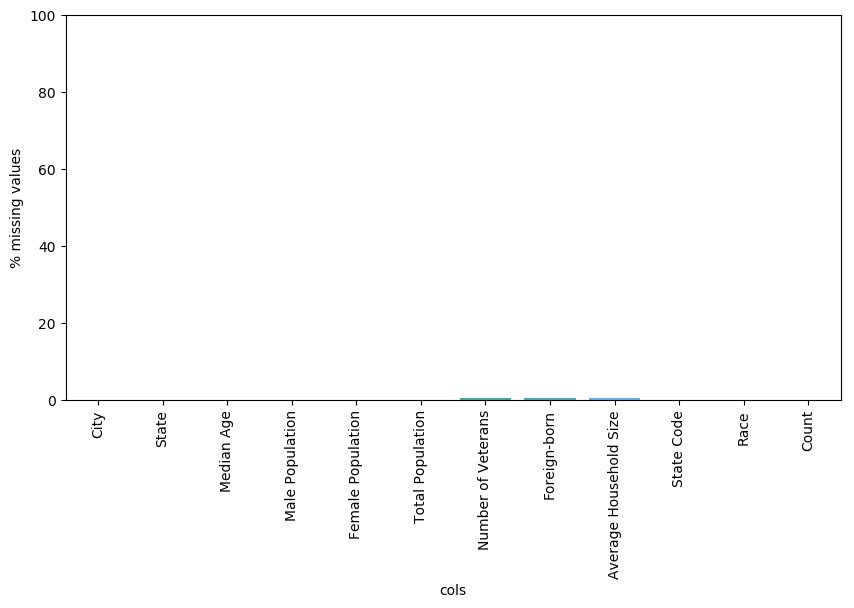

,cols,values,% missing values
0,City,0,0.000000
1,State,0,0.000000
2,Median Age,0,0.000000
3,Male Population,3,0.103770
4,Female Population,3,0.103770
5,Total Population,0,0.000000
6,Number of Veterans,13,0.449671
7,Foreign-born,13,0.449671
8,Average Household Size,16,0.553442
9,State Code,0,0.000000


2891
2891
Temperature Dataset


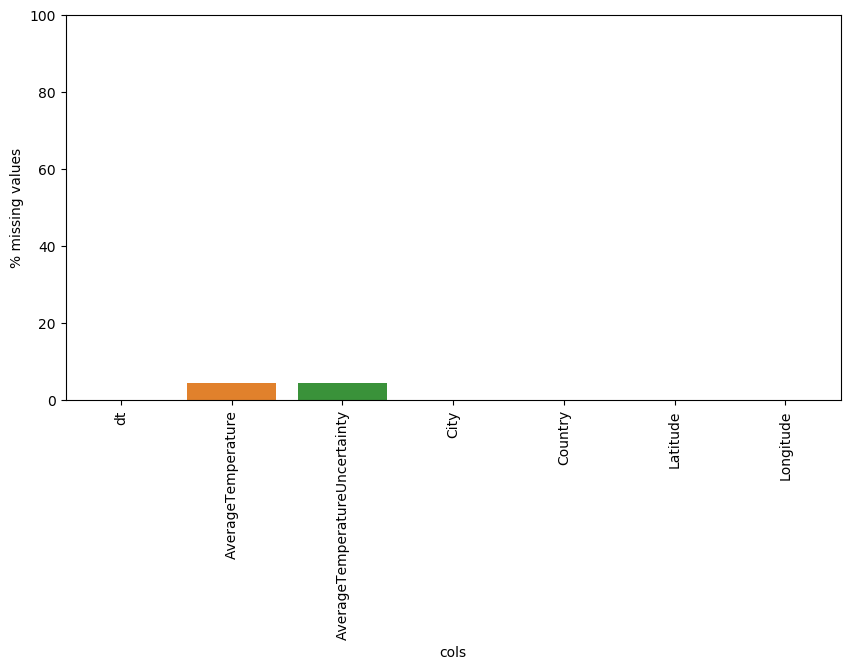

,cols,values,% missing values
0,dt,0,0.000000
1,AverageTemperature,364130,4.234458
2,AverageTemperatureUncertainty,364130,4.234458
3,City,0,0.000000
4,Country,0,0.000000
5,Latitude,0,0.000000
6,Longitude,0,0.000000


8599212
8599212
CPU times: user 12.6 s, sys: 1.95 s, total: 14.5 s
Wall time: 16 s


In [18]:
%%time
print("Airport Dataset")
df_airport_nulls = helper.view_missing_values(df_airport)
display(df_airport_nulls)
print(len(df_airport))
print(len(df_airport.drop_duplicates()))

print("Demographics Dataset")
df_demographics_nulls = helper.view_missing_values(df_demographics)
display(df_demographics_nulls)
print(len(df_demographics))
print(len(df_demographics.drop_duplicates()))

print("Temperature Dataset")
df_temperature_nulls = helper.view_missing_values(df_temperature)
display(df_temperature_nulls)
print(len(df_temperature))
print(len(df_temperature.drop_duplicates()))

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that mode
![](img/StarSchema_capstone.png)
We chose to use a star schema which is optimized for analysis on immigration events from the I94 dataset. We have the `immigration_fact` as the fact table and `demographics_dim`, `date_dim`, and `temperature_dim` as the dimension tables. This would allow end-users such as business analysts easily run queries around the correlations between immigration patterns and temperature or demographics.

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model
1. Load the datasets into Spark
2. Perform data cleaning steps previously listed for immigration, temperature, and demographics datasets
3. Create tables
    * immigration_fact table
    * date_dim table (based on arrival date)
    * temperature_dim table (average temperature for each country)
    * demographics_dim table


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

#### 1. immigration fact table

In [140]:
%%time
df_immigration = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
df_immigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [143]:
df_immigration.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,37.0,2.0,1.0,None,None,None,T,None,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,20130811,SEO,None,G,None,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,None,None,T,O,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,20160401,None,None,O,O,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,4.0,2.0,1.0,20160401,None,None,O,O,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [148]:
def create_immigration_table(df, 
                             lookup_path='I94_SAS_Labels_Descriptions.SAS', 
                             output_path="./output_data/immigration"):
    """ Create immigration fact table based off of the immigration events 
    from the I94 dataset.

    Args:
        df (Spark dataframe): input Spark dataframe with immigration data
        lookup_path (str): path to SAS data dictionary to generate country code loookup
        output_path (str): path to write the output dataframe to
    Return:
        DataFrame corresponding to date dimension table
    """
    # udf to convert arrival date to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    int_cols = ['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'arrdate', 
                'i94mode', 'i94bir', 'i94visa','dtadfile', 'depdate']
    null_cols = ['occup', 'entdepu','insnum','visapost']
    other_cols = ['count', 'matflag', 'dtaddto', 'biryear', 'admnum']
    drop_cols = null_cols + other_cols
    
    for col_name in int_cols:
        df = df.withColumn(col_name, col(col_name).cast('integer'))        
    df_immigration = df.drop(*drop_cols)
    df_immigration = df_immigration.withColumn("arrdate", get_datetime(df_immigration.arrdate))\
                                    .withColumnRenamed('cicid','record_id') \
                                    .withColumnRenamed('i94res', 'country_code') \
                                    .withColumnRenamed('i94addr', 'state_code') 
    
    # join country code
    country_lookup = helper.extract_lookup(lookup_path, 'i94cntyl', ['country_code', 'country'])
    country_lookup['country'] = country_lookup['country'].str.title()
    country_lookup = spark.createDataFrame(country_lookup)
    df_immigration = df_immigration.join(country_lookup, on='country_code', how='left')
    
    # write the fact table to parquet file
    partition_columns = ['i94yr', 'i94mon']
    df_immigration.write.parquet(output_path, 
                          partitionBy=partition_columns, 
                          mode="overwrite")
    return df_immigration

In [149]:
%%time
immigration_fact_table = create_immigration_table(df_immigration)
print(immigration_fact_table.count())
immigration_fact_table.printSchema()

3096313
root
 |-- country_code: integer (nullable = true)
 |-- record_id: integer (nullable = true)
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: string (nullable = true)
 |-- i94mode: integer (nullable = true)
 |-- state_code: string (nullable = true)
 |-- depdate: integer (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- i94visa: integer (nullable = true)
 |-- dtadfile: integer (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)
 |-- country: string (nullable = true)

CPU times: user 77.6 ms, sys: 42.6 ms, total: 120 ms
Wall time: 1min 45s


In [152]:
len(immigration_fact_table.columns)

20

In [150]:
immigration_fact_table.limit(5).toPandas()

,country_code,record_id,i94yr,i94mon,i94cit,i94port,arrdate,i94mode,state_code,depdate,i94bir,i94visa,dtadfile,entdepa,entdepd,gender,airline,fltno,visatype,country
0,243,217886,2016,4,718,HHW,2016-04-01,1,HI,20580,27,3,20160401,T,O,F,JL,782,M1,Burma
1,243,217887,2016,4,718,HHW,2016-04-01,1,HI,20587,31,3,20160401,T,O,F,JL,782,M1,Burma
2,243,217888,2016,4,718,NYC,2016-04-01,1,NY,20552,55,1,20160401,O,O,None,SQ,00026,B1,Burma
3,243,217891,2016,4,718,BOS,2016-04-01,1,MA,20550,47,1,20160401,G,O,M,QR,00743,B1,Burma
4,243,217892,2016,4,718,BOS,2016-04-01,1,MA,20550,38,1,20160401,G,O,F,QR,00743,B1,Burma


#### 2. date dimension table

In [133]:
def create_date_table(df, output_path="./output_data/date"):
    """ Creates a date dimension table based off of the arrival dates from the 
    immigration events.

    Args:
        df (Spark dataframe): input Spark dataframe with demographics data
        output_path (str): path to write the output dataframe to
    Return:
        DataFrame corresponding to date dimension table
    """

    # udf to convert arrival date to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)

    # use arrival date to create dataframe
    df_date = df.select(['arrdate']).withColumn("arrdate", get_datetime(df.arrdate)).distinct()
    df_date = df_date.withColumn('date_id', monotonically_increasing_id())
    df_date = df_date.withColumn('arrival_day', dayofmonth('arrdate'))
    df_date = df_date.withColumn('arrival_week', weekofyear('arrdate'))
    df_date = df_date.withColumn('arrival_month', month('arrdate'))
    df_date = df_date.withColumn('arrival_year', year('arrdate'))
    df_date = df_date.withColumn('arrival_weekday', dayofweek('arrdate'))
    

    # write the calendar dimension to parquet file
    partition_columns = ['arrival_year', 'arrival_month', 'arrival_week']
    df_date.write.parquet(output_path, partitionBy=partition_columns, mode="overwrite")

    return df_date

In [134]:
%%time
date_dim_table = create_date_table(df_immigration)
print(date_dim_table.count())
date_dim_table.printSchema()

30
root
 |-- arrdate: string (nullable = true)
 |-- date_id: long (nullable = false)
 |-- arrival_day: integer (nullable = true)
 |-- arrival_week: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_weekday: integer (nullable = true)

CPU times: user 81.6 ms, sys: 5.2 ms, total: 86.8 ms
Wall time: 1min 31s


In [21]:
print(df_immigration.count())

3096313


In [22]:
%%time
print(df_immigration.select('arrdate').distinct().count())

30
CPU times: user 5.49 ms, sys: 241 µs, total: 5.73 ms
Wall time: 29.6 s


In [155]:
date_dim_table.limit(5).toPandas()

,arrdate,date_id,arrival_day,arrival_week,arrival_month,arrival_year,arrival_weekday
0,2016-04-22,8589934592,22,16,4,2016,6
1,2016-04-15,25769803776,15,15,4,2016,6
2,2016-04-18,42949672960,18,16,4,2016,2
3,2016-04-09,68719476736,9,14,4,2016,7
4,2016-04-11,85899345920,11,15,4,2016,2


#### 3. temperature dimension table

In [33]:
def create_temperature_table(df, output_path="./output_data/temperature"):
    """ Creates a temperature dimension table based on the World Temperature dataset 
    from Kaggle. The average temperature data is aggregated at the country level.

    Args:
        df (Spark dataframe): input Pandas dataframe with temperature records
        output_path (str): path to write the output dataframe to
    Return:
        DataFrame corresponding to temperature dimension table
    """
    df_temperature = df[['Country', 'AverageTemperature']]\
                            .dropna(how='any')\
                            .groupby('Country')['AverageTemperature'].mean()\
                            .reset_index()
    df_temp = spark.createDataFrame(df_temperature)
    df_temp.repartition(1)\
          .write.parquet(output_path, mode="overwrite")
    return df_temp

In [34]:
%%time
df_temperature = pd.read_csv('../../data2/GlobalLandTemperaturesByCity.csv')
df_temperature.info()
temperature_dim_table = create_temperature_table(df_temperature)
print(temperature_dim_table.count())
temperature_dim_table.printSchema()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB
159
root
 |-- Country: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)

CPU times: user 9.87 s, sys: 1.53 s, total: 11.4 s
Wall time: 12.9 s


In [27]:
temperature_dim_table.toPandas().head(10)

,Country,AverageTemperature
0,Afghanistan,13.816497
1,Albania,15.525828
2,Algeria,17.763206
3,Angola,21.759716
4,Argentina,16.999216
5,Armenia,8.375597
6,Australia,16.701462
7,Austria,6.285928
8,Azerbaijan,11.113664
9,Bahamas,24.786978


#### 4. demographics dimension table

In [41]:
print(len(df_demographics[['City', 'State', 'State Code', 'Race']].drop_duplicates()))
print(len(df_demographics))

2891
2891


In [35]:
## demographics dimension table
def create_demographics_table(df, output_path="./output_data/demographics"):
    """ Creates a demographics dimension table based on the US City Demographic Data.

    Args:
        df (Spark dataframe): input Spark dataframe with immigration events
        output_path (str): path to write the output dataframe to
    Return:
        DataFrame corresponding to demographics dimension table
    """
    # clean demographics dataset
    subset_cols = ['Male Population', 'Female Population', 'Number of Veterans',
                   'Foreign-born', 'Average Household Size']
    
    
    df_demographics = df.dropna(subset=subset_cols)
    
    df_demographics = df_demographics.withColumn('demographics_id', monotonically_increasing_id()) \
                                    .withColumnRenamed('Median Age','median_age') \
                                    .withColumnRenamed('Male Population', 'male_population') \
                                    .withColumnRenamed('Female Population', 'female_population') \
                                    .withColumnRenamed('Total Population', 'total_population') \
                                    .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
                                    .withColumnRenamed('Foreign-born', 'foreign_born') \
                                    .withColumnRenamed('Average Household Size', 'average_household_size') \
                                    .withColumnRenamed('State Code', 'state_code') \
                                    .withColumnRenamed('City', 'city') \
                                    .withColumnRenamed('State', 'state') \
                                    .withColumnRenamed('Race', 'race') \
                                    .withColumnRenamed('Count', 'count')
    
    # write dimension to parquet file
    df_demographics.repartition(1)\
                   .write.parquet(output_path, mode="overwrite")
    
    return df_demographics


In [36]:
%%time
df_demographics_spark = spark.read.csv('us-cities-demographics.csv', inferSchema=True, header=True, sep=';')
demographics_dim_table = create_demographics_table(df_demographics_spark)
print(demographics_dim_table.count())
demographics_dim_table.printSchema()

2875
root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- number_of_veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- average_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- demographics_id: long (nullable = false)

CPU times: user 12.9 ms, sys: 3.47 ms, total: 16.4 ms
Wall time: 2.17 s


In [37]:
demographics_dim_table.toPandas().head()

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,count,demographics_id
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924,0
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723,1
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759,2
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437,3
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402,4


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks  
For each table, check for:
1. records exist
2. no duplicate records

In [196]:
def check_data_quality(df, table_name):
    """ Run the following data quality checks for a given dataframe:
    1. records exist
    2. no duplicate records
    
    If any of the checks fail, then 
    
    Args:
        df (Spark dataframe): input Spark dataframe with immigration events
    Return:
        None
    """
    print(f'Starting data quality checks for {table_name}...')
    
    count = df.count()
    if count == 0:
        raise ValueError(f"Data quality check #1 failed: {table_name} has zero records!")
        
    if count != df.distinct().count():
        raise ValueError(f"Data quality check #2 failed: {table_name} has duplicate records!")
        
    print(f"All data quality checks have passed for: {table_name} which has {count} records!")

In [197]:
%%time
all_dfs = {
    'immigration fact table': immigration_fact_table,
    'temperature dimension table': temperature_dim_table,
    'date dimension table': date_dim_table,
    'demographics dimension table': demographics_dim_table
}
for table_name, df in all_dfs.items():
    check_data_quality(df, table_name)

Starting data quality checks for immigration fact table...
All data quality checks have passed for: immigration fact table which has 3096313 records!
Starting data quality checks for temperature dimension table...
All data quality checks have passed for: temperature dimension table which has 159 records!
Starting data quality checks for date dimension table...
All data quality checks have passed for: date dimension table which has 30 records!
Starting data quality checks for demographics dimension table...
All data quality checks have passed for: demographics dimension table which has 2875 records!
CPU times: user 115 ms, sys: 29.5 ms, total: 145 ms
Wall time: 3min 7s


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Immigration Fact Table
From the I94 Immigration Dataset with immigration events.

| Column       | Description                                                                           |
|--------------|---------------------------------------------------------------------------------------|
| record_id    | Unique ID for a given record                                                          |
| country_code | 3 digit code for immigrant country of residence                                       |
| i94yr        | 4 digit year                                                                          |
| i94mon       | Numeric month                                                                         |
| i94cit       | 3 digit code for immigrant country of birth                                           |
| i94port      | Port of admission                                                                     |
| arrdate      | Arrival date in the USA                                                               |
| i94mode      | Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)                 |
| state_code   | State of arrival in the USA                                                           |
| depdate      | Departure Date from the USA.                                                          |
| i94bir       | Age of Respondent in Years                                                            |
| i94visa      | Visa codes collapsed into three categories: (1 = Business; 2 = Pleasure; 3 = Student) |
| dtadfile     | Character Date Field - Date added to I-94 Files                                       |
| entdepa      | Arrival Flag - admitted or paroled into the U.S.                                      |
| entdepd      | Departure Flag - Departed, lost I-94 or is deceased                                   |
| gender       | Non-immigrant sex                                                                     |
| airline      | Airline used to arrive in U.S.                                                        |
| fltno        | Flight number of Airline used to arrive in U.S.                                       |
| visatype     | Class of admission legally admitting the non-immigrant to temporarily stay in U.S.    |
| country      | Country of residence                                                                  |

#### Temperature Dimension Table
From the World Temperature Dataset from Kaggle - average temperature aggregated to the monthly level.

| Column              | Description                                           |
|---------------------|-------------------------------------------------------|
| country             | country name                                          |
| average_temperature | mean of recorded temperatures for a country (Celsius) |

#### Date Dimension Table
Arrival dates from the I94 Immigration Dataset.

| Column          | Description        |
|-----------------|--------------------|
| date_id         | unique id          |
| arrival_day     | day of arrival     |
| arrival_week    | week of arrival    |
| arrival_month   | month of arrival   |
| arrival_year    | year of arrival    |
| arrival_weekday | weekday of arrival |
| arrdate         | arrival date       |

#### Demographics Dimension Table
From the OpenSoft demographics dataset.

| Column                 | Description                                  |
|------------------------|----------------------------------------------|
| demographics_id        | unique id                                    |
| city                   | Name of US city                              |
| state                  | Name of US state                             |
| median_age             | Median age of city population                |
| male_population        | Count of male population in the city         |
| female_population      | Count of female population in the city       |
| total_population       | Count of total population in the city        |
| number_veterans        | Count of veterans in the city                |
| foreign_born           | Count of foreign born population in the city |
| average_household_size | Average household size in the city           |
| state_code             | State code (abbreviation)                    |
| race                   | Race                                         |
| count                  | Count of individuals by race                 |

#### Step 5: Complete Project Write Up
* *Clearly state the rationale for the choice of tools and technologies for the project.*
    * **We used Python scripts to create functions for our EDA and initial preprocessing via robust libraries such as matplotlib and pandas.** 
    * **We utilized Apache Spark due to its ability to handle large amounts of data quickly and efficiently and provides APIs that allows for us to perform analytics, especially on the immigration dataset.**
    * **As we did in the previous projects, we could also utilize Apache Airflow for scheduling and orchestrating our ETL workflow and Amazon Redshift to store our analytics data warehouse.** 
* *Propose how often the data should be updated and why.* **The data should be updated once a month since it seems that the I94 data files are generated monthly based on the listing we previously did.**
* Write a description of how you would approach the problem differently under the following scenarios:
 * *The data was increased by 100x.* **We could use Amazon EMR to scale up our Spark cluster with which we would perform our data preprocessing and Amazon Redshift to store our updated stage, fact, and dimension tables**
 * *The data populates a dashboard that must be updated on a daily basis by 7am every day.* **We could just use Apache Airflow to schedule our pipeline daily via a DAG and add a final task to pull the needed data to the dashboard.**
 * *The database needed to be accessed by 100+ people.* **We would move our database into Amazon Redshift and ensure the concurrency scaling feature is enabled, and possible create roles for different user personas**